In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
rng = np.random.default_rng(7)

In [3]:
# Initialise parameters:
num_of_agents = 100 # number of agents
Timesteps = 100 # timesteps (1 = no steps taken) in years
R = 0.2 # confidence bound


min_age = 16
max_age = 81
op_drift = 0.01

youth_min_op = 0
youth_max_op = 0.4
youth_op_mu = 0.2
youth_op_std = 0.05
imp_decay=0.93

In [75]:
opinions = np.random.rand(num_of_agents) # init all agents to [0,1]

a=16; b=80; std = 15; mu = 40
rv = sc.stats.truncnorm((a-mu)/std, (b-mu)/std, loc=mu, scale=std)
ages = np.floor(rv.rvs(size=num_of_agents))

d_imp_std = 0.03; d_imp_mu = 0.05
rv_imp = sc.stats.truncnorm((a-mu)/std, (b-mu)/std, loc=d_imp_mu, scale=d_imp_std)
d_imp = rv_imp.rvs(size=num_of_agents)

imp = np.ones(num_of_agents) - d_imp

array([0.98884469, 0.91096756, 0.99705356, 0.91467335, 0.96475239,
       0.92426799, 0.96142105, 0.95604156, 0.98709483, 0.92857748,
       0.92383567, 0.96862909, 0.9777753 , 0.88787247, 0.91950753,
       0.95905034, 0.95624594, 0.93785507, 0.97447509, 0.95967815,
       0.97675455, 0.9468124 , 0.98493873, 0.98403383, 0.98032673,
       0.96094982, 0.95989299, 0.96265348, 0.94111343, 0.95761257,
       0.96120186, 0.94854668, 0.98150399, 0.95371075, 0.89518075,
       0.96636295, 0.93384754, 0.95152497, 0.9531259 , 0.90824215,
       0.96321826, 0.91488893, 0.90974639, 0.96521766, 0.93954284,
       0.98861949, 0.95754466, 0.99759533, 0.94691232, 0.98631818,
       0.93640066, 0.9737691 , 0.92064508, 0.91736844, 0.93682769,
       0.94021889, 0.92216286, 0.92771295, 0.97068741, 0.94601409,
       0.95614991, 0.94015693, 0.93708005, 0.91236966, 0.93657629,
       0.96550848, 0.94274222, 0.92205627, 0.905705  , 0.98488781,
       0.97428401, 0.93717797, 0.97376115, 0.93850591, 0.94342

In [20]:
def get_A(opinions,R):
    '''
    A function to return the average opinion within R of each opinion in a vector of opinions
    '''
    
    num_of_agents = len(opinions)

    # Create a square matrix consisting of the opinions vector repeated num_of_agents times
    opinions_repeated = np.array([opinions]*len(opinions))
    # Create matrix of boolean values indicating which opinions are within R of each opinion
    mask = abs(opinions_repeated - opinions_repeated.T) < R
    
    # Initialise averages matrix
    A = np.zeros(num_of_agents)

    # Loop over agents
    for i in range(num_of_agents):
        # Get average of opinions within R of opinion
        A[i] = np.mean(opinions[mask[i,:]])
        # print(A[i])
    
    return(A)

In [70]:
# Running model

# Initialising matrix of opinions over time
opinions_over_time = np.zeros((Timesteps, num_of_agents))
opinions_over_time[0,:] = opinions

# Initialising matrix of ages over time
ages_over_time = np.zeros((Timesteps,num_of_agents))
ages_over_time[0,:] = ages

# imp_over_time = np.zeros((Timesteps,num_of_agents))
# imp_over_time[0,:] = imp#np.ones(num_of_agents)#imp


for t in range(Timesteps-1):
    mask1 = ages_over_time[t, :] < 40
    mask2 = ages_over_time[t, :] > 55

    x = np.random.randn(num_of_agents)
    scale_lo=0.0; scale_hi=0.1; scale_std = 0.01; scale_mu = 0.05
    rv_scale = sc.stats.truncnorm((scale_lo-scale_mu)/scale_std, (scale_hi-scale_mu)/scale_std, loc=scale_mu, scale=scale_std)
    scale = rv_scale.rvs(size=num_of_agents)
    #scale = np.ones(num_of_agents)
    
    # Basic opinion update (minimum necesssary to keep opinions within a range)
    opinions_over_time[t+1,:] = np.minimum(imp_over_time[t,:] * get_A(opinions_over_time[t,:], R) + op_drift, 1.0)
    
    # Update ages
    ages_over_time[t+1,:] = ages_over_time[t,:] + 1

    # Update impressionability as function of age
    imp_over_time[t+1,:] = np.ones(num_of_agents)
    imp_over_time[t+1,mask1] = np.ones(np.sum(mask1)) - np.abs(imp_over_time[t,mask1] - np.ones(np.sum(mask1))) * 0.78
    imp_over_time[t+1,mask2] = np.ones(np.sum(mask2)) - np.abs(imp_over_time[t,mask2] - np.ones(np.sum(mask2))) * 0.99
    
    # Find who dies at next step
    deaths = ages_over_time[t+1,:] > max_age
    num_deaths = sum(deaths)

    # Replace the people who die with young people
    ages_over_time[t+1, deaths] = min_age

    # Initialise new people with uniformly distributed opinions within some range
    #opinions_over_time[t+1,:][deaths] = (youth_max_op - youth_min_op) * np.random.random(num_deaths) + youth_min_op 

    # Initialise new people with normally-distributed opinions within some range
    rv = sc.stats.truncnorm((youth_min_op-youth_op_mu)/youth_op_std, 
                        (youth_max_op-youth_op_mu)/youth_op_std, loc=youth_op_mu, scale=youth_op_std)
    opinions_over_time[t+1,:][deaths] = rv.rvs(size=num_deaths)
    
    
# print(opinions_over_time)
# print(ages_over_time)

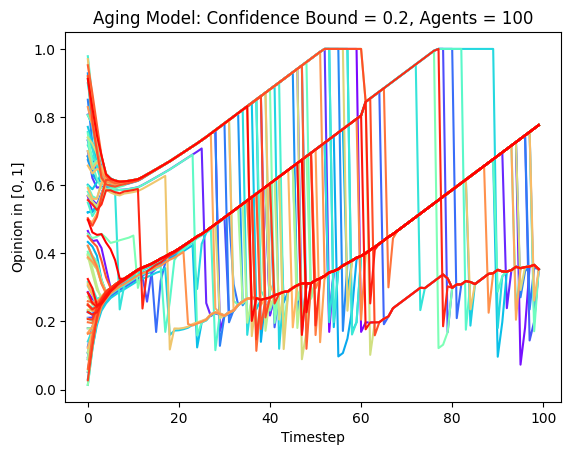

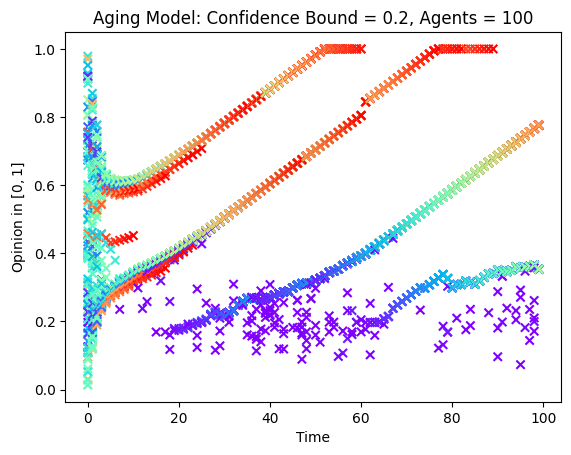

In [71]:
#plotting
colours = plt.cm.rainbow(np.linspace(0,1,num_of_agents))

for i in range(num_of_agents):
    plt.plot(opinions_over_time[:,i],color=colours[i])
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Timestep')
plt.ylabel('Opinion in $[0,1]$')
plt.show()

#plotting

colours = plt.cm.rainbow(np.linspace(0,1,round(max_age-min_age+1)))
plt.scatter(np.array([range(Timesteps)]*num_of_agents).T, opinions_over_time, c=ages_over_time, cmap='rainbow', marker='x')
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Time')
plt.ylabel('Opinion in $[0,1]$')
plt.show()